# NEI Comparison
Compare the IonPopSolver code and our new NEI solver for a few different cases

In [177]:
import os
import subprocess
import numpy as np
import plasmapy
import scipy.interpolate
import matplotlib.pyplot as plt
import astropy.units as u
import fiasco
from synthesizAR.atomic import Element
from synthesizAR.util import InputHandler,OutputHandler

%matplotlib inline

## Functions for Dealing with IonPopSolver

In [54]:
def run_ionpopsolver(element,time,temperature,density):
    atomic_number = plasmapy.atomic.atomic_number(element)
    # Print to file
    np.savetxt('test.ips.input',np.vstack([time,temperature,density]).T,
           header='{}'.format(time.shape[0]),comments='',fmt='%f\t%e\t%e')
    # Run the code
    subprocess.call([
        '/Users/willbarnes/Documents/work/codes/IonPopSolver/bin/IonPopSolver.run',
        '-Z',f'{atomic_number}','-f','1','-t',f'{atomic_number+1}',
        '-I','test.ips.input',
        '-O','test.ips.output',
        '-r','/Users/willbarnes/Documents/work/codes/IonPopSolver/test/radiation.local.cfg.xml'
    ])
    # Read in results
    tmp = np.loadtxt('test.ips.output')
    time_ips = tmp[:,0]
    y = tmp[:,4:]
    
    return time_ips,y

In [55]:
def read_ips_balance(element):
    with open('/Users/willbarnes/Documents/work/codes/apolloDB/balances/ips_01dex/{}.bal'.format(element.lower()),
              'r') as f:
        lines = f.readlines()
    ioneq = np.zeros((len(lines),len(lines[0].split())-1),dtype=np.float64)
    temperature_grid= np.zeros((len(lines),),dtype=np.float64)
    for i,line in enumerate(lines):
        line = line.split()
        temperature_grid[i] = line[0]
        ioneq[i,:] = line[1:]
        
    return temperature_grid,ioneq

In [56]:
def read_ips_rates(element,temperature_grid):
    with open('/Users/willbarnes/Documents/work/codes/apolloDB/rates/ips_01dex/{}.rts'.format(element.lower()), 'r') as f:
        lines = f.readlines()
    rates = {'ionization':{},'recombination':{}}
    current_ds = 'ionization'
    for l in lines:
        if not l.strip():
            continue
        if element.capitalize() in l:
            ion_name = l.strip()
            if ion_name in rates[current_ds]:
                current_ds = 'recombination'
            rates[current_ds][ion_name] = []
            continue
        rates[current_ds][ion_name] += l.strip().split()
    for k in rates['ionization']:
        rates['ionization'][k] = np.array(rates['ionization'][k],dtype=np.float64)
    last_charge_state = int(k.split('+')[1])+1
    # ionization rate of fully-ionized should be 0
    rates['ionization'][f'{element.capitalize()}+{last_charge_state}'] = np.zeros(temperature_grid.shape) 
    for k in rates['recombination']:
        rates['recombination'][k] = np.array(rates['recombination'][k],dtype=np.float64)
    rev_keys = sorted(rates['recombination'].keys(),key=lambda x:int(x.split('+')[1]),reverse=True)
    for rk in rev_keys:
        charge_state = int(rk.split('+')[1])
        new_key = f'{element.capitalize()}+{charge_state+1}'
        rates['recombination'][new_key] = rates['recombination'][rk]
    rates['recombination'][rk] = np.zeros(temperature_grid.shape)
    
    return rates

In [57]:
def make_rate_matrix(element):
    temperature,_ = read_ips_balance(element)
    rates = read_ips_rates(element, temperature)
    ionization_rate = rates['ionization']
    recombination_rate = rates['recombination']
    atomic_number = plasmapy.atomic.atomic_number(element)
    rate_matrix = np.zeros(temperature.shape + (atomic_number+1, atomic_number+1))
    for i in range(1, atomic_number):
        rate_matrix[:, i, i] = -(ionization_rate[f'{element}+{i}'] + recombination_rate[f'{element}+{i}'])
        rate_matrix[:, i, i-1] = ionization_rate[f'{element}+{i-1}']
        rate_matrix[:, i, i+1] = recombination_rate[f'{element}+{i+1}']
    rate_matrix[:, 0, 0] = -(ionization_rate[f'{element}+0'] + recombination_rate[f'{element}+0'])
    rate_matrix[:, 0, 1] = recombination_rate[f'{element}+1']
    rate_matrix[:, -1, -1] = -(ionization_rate[f'{element}+{atomic_number}'] 
                               + recombination_rate[f'{element}+{atomic_number}'])
    rate_matrix[:, -1, -2] = ionization_rate[f'{element}+{atomic_number-1}']

    return u.Quantity(10.**temperature,u.K), u.Quantity(rate_matrix,u.cm**3/u.s)

## Functions for Generating Sample $T(t)$ and $n(t)$ Curves

In [58]:
def make_sample_data(time,t_rise,t_peak,t_end,x_rise,x_peak,x_end):
    x = np.zeros(time.shape)
    x = np.where(time<=t_rise,x_rise, x)
    x = np.where(time>=t_end, x_end, x)
    x = np.where(np.logical_and(time>t_rise,time<t_peak),
                 (time - t_rise)*(x_peak-x_rise)/(t_peak - t_rise) + x_rise, x)
    x = np.where(np.logical_and(time>=t_peak,time<t_end), 
                 (time - t_peak)*(x_end - x_peak)/(t_end - t_peak) + x_peak, x)
    
    return u.Quantity(x,x_rise.unit)

## Case 1

In [276]:
time = np.linspace(0,30,300)*u.s
temperature = make_sample_data(time.value,0,15,30,1e5*u.K,1e7*u.K,1e5*u.K)
density = make_sample_data(time.value,0,15,30,1e8*u.cm**(-3),1e10*u.cm**(-3),1e8*u.cm**(-3))

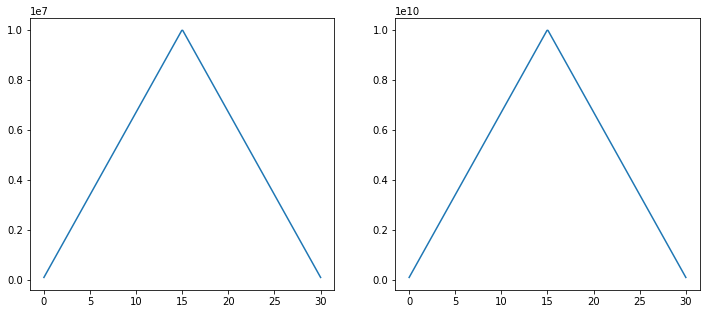

In [277]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(time,temperature)
plt.subplot(122)
plt.plot(time,density)

In [278]:
temperature_grid,rate_matrix = make_rate_matrix('Fe')

In [279]:
element = Element('Fe',temperature_grid)

In [280]:
nei_fiasco = element.non_equilibrium_ionization(time,temperature,density,rate_matrix=rate_matrix)

In [281]:
time_ips,nei_ips = run_ionpopsolver('Fe',time.value,temperature.value,density.value)

Text(0,0.5,'Ionization Fraction')

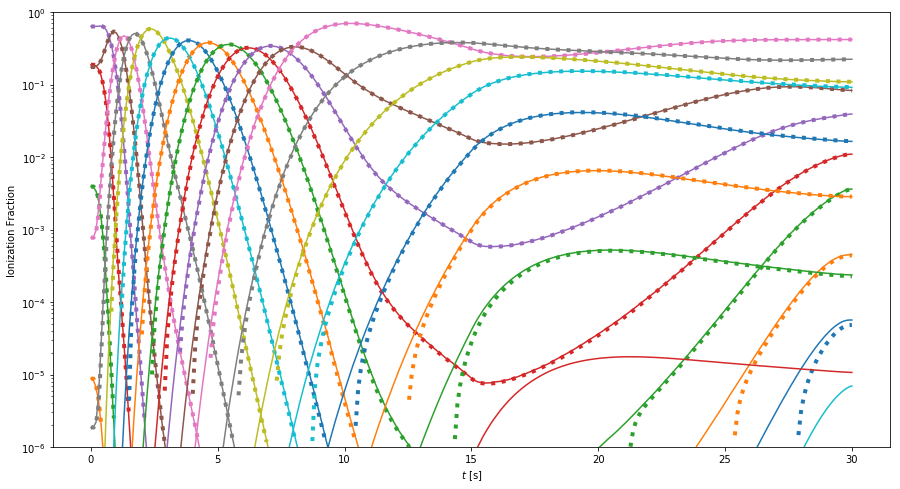

In [282]:
plt.figure(figsize=(15,8))
for i in range(element.atomic_number+1):
    plt.plot(time,nei_fiasco[:,i],ls='-',color=f'C{i%10}',label=f'{i}')
    plt.plot(time_ips,nei_ips[:,i],ls=':',lw=4,color=f'C{i%10}',label=f'{i}')
plt.yscale('log')
plt.ylim(1e-6,1)
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'Ionization Fraction')

## Case 2
Note that I've used a static timestep of 0.001 s here. 0.01 works OK, but there are large oscillations below $10^{-4}$

In [292]:
time = np.linspace(0,30,3000)*u.s
temperature = make_sample_data(time.value,0,15,30,1e5*u.K,5e7*u.K,1e5*u.K)
density = make_sample_data(time.value,0,15,30,1e12*u.cm**(-3),1e12*u.cm**(-3),1e12*u.cm**(-3))

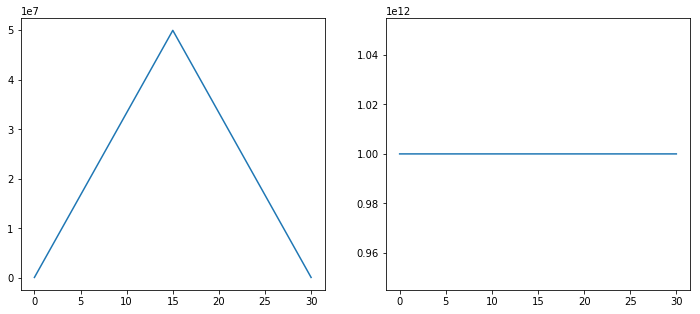

In [293]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(time,temperature)
plt.subplot(122)
plt.plot(time,density)

In [294]:
nei_fiasco = element.non_equilibrium_ionization(time,temperature,density,rate_matrix=rate_matrix)

In [295]:
time_ips,nei_ips = run_ionpopsolver('Fe',time.value,temperature.value,density.value)

Text(0,0.5,'Ionization Fraction')

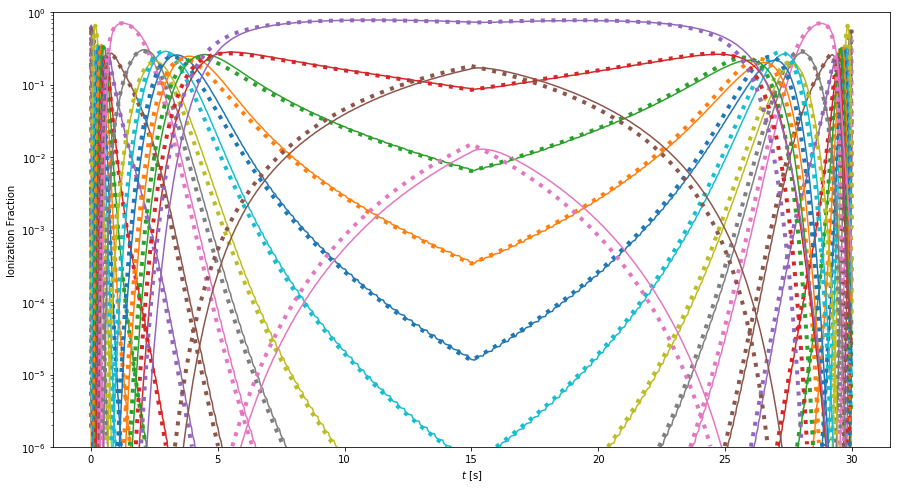

In [296]:
plt.figure(figsize=(15,8))
for i in range(element.atomic_number+1):
    plt.plot(time,nei_fiasco[:,i],ls='-',color=f'C{i%10}',label=f'{i}')
    plt.plot(time_ips,nei_ips[:,i],ls=':',lw=4,color=f'C{i%10}',label=f'{i}')
plt.yscale('log')
plt.ylim(1e-6,1)
#plt.xscale('log')
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'Ionization Fraction')

## Case 3

In [271]:
time = np.linspace(0,30,3000)*u.s
temperature = make_sample_data(time.value,10,15,20,1e5*u.K,1e7*u.K,1e5*u.K)
density = make_sample_data(time.value,0,15,30,
                           1e12*u.cm**(-3),
                           1e12*u.cm**(-3),
                           1e12*u.cm**(-3))

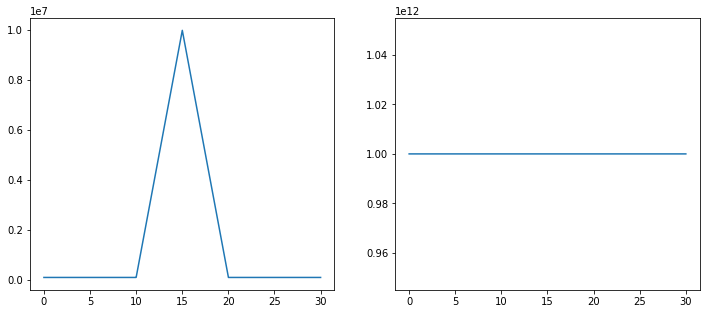

In [272]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(time,temperature)
plt.subplot(122)
plt.plot(time,density)

In [273]:
nei_fiasco = element.non_equilibrium_ionization(time,temperature,density,rate_matrix=rate_matrix)

In [274]:
time_ips,nei_ips = run_ionpopsolver('Fe',time.value,temperature.value,density.value)

Text(0,0.5,'Ionization Fraction')

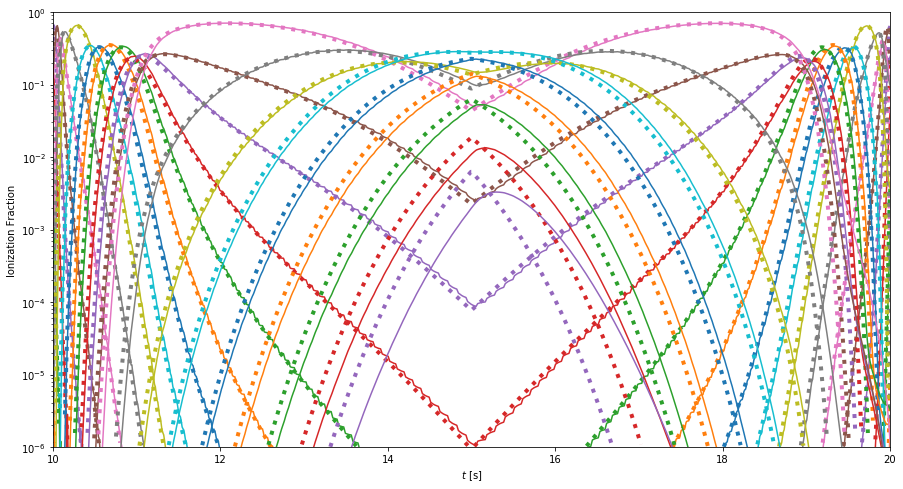

In [275]:
plt.figure(figsize=(15,8))
for i in range(element.atomic_number+1):
    plt.plot(time,nei_fiasco[:,i],ls='-',color=f'C{i%10}',label=f'{i}')
    plt.plot(time_ips,nei_ips[:,i],ls=':',lw=4,color=f'C{i%10}',label=f'{i}')
plt.yscale('log')
plt.ylim(1e-6,1)
plt.xlim(10,20)
#plt.xscale('log')
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'Ionization Fraction')

## Case 4

In [253]:
time = np.linspace(0,500,5000)*u.s
temperature = make_sample_data(time.value,0,20,150,1e5*u.K,1e7*u.K,5e5*u.K)
density = make_sample_data(time.value,0,100,500,
                           5e7*u.cm**(-3),
                           5e10*u.cm**(-3),
                           1e8*u.cm**(-3))

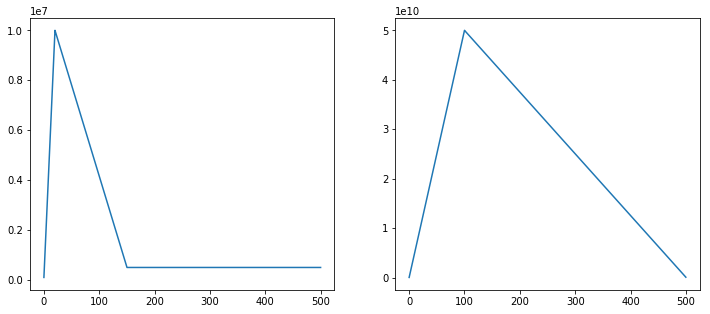

In [254]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(time,temperature)
plt.subplot(122)
plt.plot(time,density)

In [255]:
nei_fiasco = element.non_equilibrium_ionization(time,temperature,density,rate_matrix=rate_matrix)

In [256]:
time_ips,nei_ips = run_ionpopsolver('Fe',time.value,temperature.value,density.value)

Text(0,0.5,'Ionization Fraction')

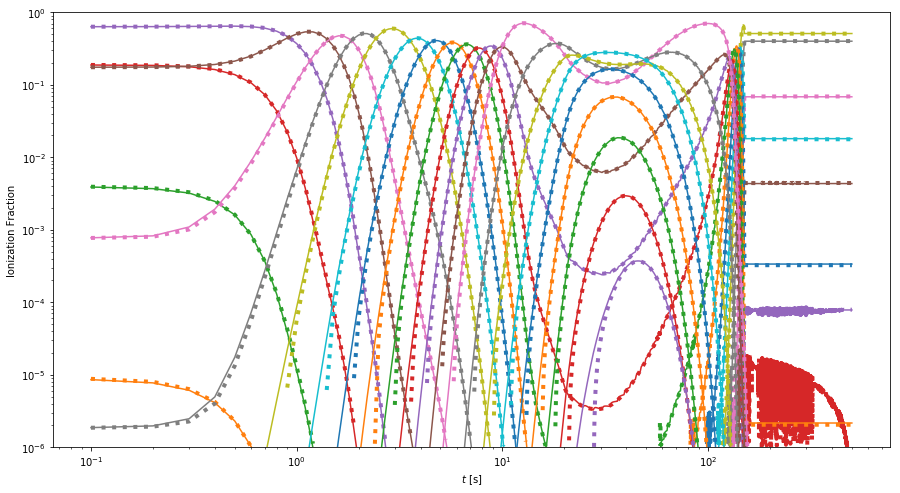

In [257]:
plt.figure(figsize=(15,8))
for i in range(element.atomic_number+1):
    plt.plot(time,nei_fiasco[:,i],ls='-',color=f'C{i%10}',label=f'{i}')
    plt.plot(time_ips,nei_ips[:,i],ls=':',lw=4,color=f'C{i%10}',label=f'{i}')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-6,1)
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'Ionization Fraction')

## Case 5
Do an actual EBTEL run

In [298]:
base_config = InputHandler('/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml').lookup_vars()
base_config['heating']['events'] = [
    {'event':{'decay_start':100,'decay_end':200,'rise_start':0,'rise_end':100,'magnitude':0.1}},
]
base_config['heating']['background'] = 1e-6
base_config['output_filename'] = 'ebtel_test'
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['use_flux_limiting'] = True
base_config['adaptive_solver_error'] = 1e-8
base_config['adaptive_solver_safety'] = 0.5
oh = OutputHandler(f"{base_config['output_filename']}.xml",base_config)
oh.print_to_xml()

In [299]:
subprocess.call([
    '/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/bin/ebtel++.run',
    '-c',f'{oh.output_filename}'
])

0

In [300]:
tmp = np.loadtxt(f"{base_config['output_filename']}")
time = tmp[:,0]*u.s
temperature = tmp[:,1]*u.K
density = tmp[:,3]*u.cm**(-3)

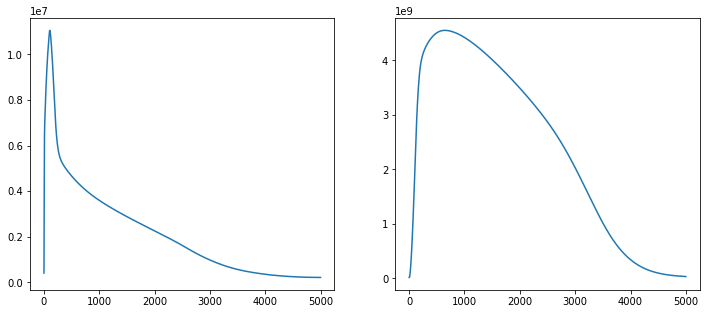

In [301]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(time,temperature)
plt.subplot(122)
plt.plot(time,density)

In [302]:
#%%timeit -n 1
nei_fiasco = element.non_equilibrium_ionization(time,temperature,density,rate_matrix=rate_matrix)

In [303]:
#%%timeit -n 1 -r 1
time_ips,nei_ips = run_ionpopsolver('Fe',time.value,temperature.value,density.value)

Text(0,0.5,'Ionization Fraction')

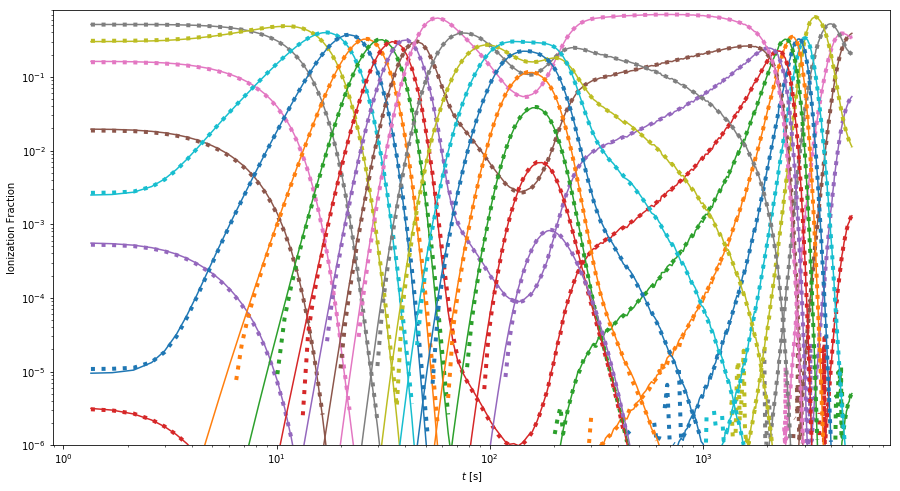

In [304]:
plt.figure(figsize=(15,8))
for i in range(element.atomic_number+1):
    plt.plot(time,nei_fiasco[:,i],ls='-',color=f'C{i%10}',label=f'{i}')
    plt.plot(time_ips,nei_ips[:,i],ls=':',lw=4,color=f'C{i%10}',label=f'{i}')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-6,.8)
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'Ionization Fraction')